In [133]:
# import packages
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import Bio
import statsmodels.api as sm


Import datasets and define variables

In [134]:
# import data from computer
path: str = './data/' #folder where files are stored
species: pd.DataFrame = pd.read_csv(os.path.join(path, "cross-species.csv"), dtype=str)   # imports file from the folder as species, based on name
identifiers: pd.DataFrame = pd.read_csv(os.path.join(path, "identifiers.tsv"), sep='\t', dtype=str) # imports 3rd file from the folder, based on name

#import fasta file with biopython (Bio)
from Bio import SeqIO
fasta_id = []
fasta_seq = []
with open(os.path.join(path, "identifiers.fasta"), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"): 
        fasta_id.append(record.id) 
        fasta_seq.append(str(record.seq))
# Create df prot_seq which includes proper ID and sequences
fasta_id_df = pd.DataFrame([item.split('|') for item in fasta_id], columns=['0', 'From','ID']) # creates a df by splitting fasta_id list into 3 columns
fasta_id_EntryName:list = fasta_id_df['ID'] # creates a list with the Entry Names from the split df
prot_seq = pd.DataFrame(list(zip(fasta_id_EntryName, fasta_seq)), columns = ["ID", "Sequence"]) # creates a df by combining the Entry Names and the Sequences



#Define datatype for each column
species['fold_change'] = species['fold_change'].astype('float64') # changes fold_change column to float64
species['temperature'] = species['temperature'].astype('float64') # changes temperature column to int64
identifiers['Length'] = identifiers['Length'].astype('float64') # changes Length column to int64

#Update index
species = species.reset_index(drop=True) # resets index of species df
identifiers = identifiers.reset_index(drop=True) # resets index of identifiers df




Add protein sequence from protein_seq dataset to identifiers to create identifiers_seq, based on 'ID' and 'Entry Name' respectively

Create joint data set from identifiers_seq and species_seq based on gene_name and Gene Names1 respectively

In [135]:
# merge dataframes based on Entry Name (df.identifiers) andID (df.prot_seq), if they are similar add the sequence to identifiers, if not add NaN
identifiers_seq = identifiers.merge(prot_seq, how='left', left_on='Entry Name', right_on='ID')[identifiers.columns.tolist() + ['Sequence']] # merges identifiers and prot_seq on Entry Name and ID
identifiers_seq.head()

#merge species and identifiers_seq based on gene_name and Gene Names1
identifiers_seq[['Gene Names1', 'Gene Names2']] = identifiers_seq['Gene Names'].str.split(expand = True, n=1) # splits the Gene Names column into 2 columns
species_seq = pd.merge(left = species, right = identifiers_seq, how='outer', left_on='gene_name', right_on='Gene Names1') # merges species and identifiers_seq on gene_name and Gene Names1
species_seq.head()

,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature,From,Entry,Reviewed,...,Gene Names,Organism,Length,Gene Ontology (biological process),Gene Ontology (cellular component),Gene Ontology (molecular function),Temperature dependence,Sequence,Gene Names1,Gene Names2
0,Mus musculus BMDC lysate,Q8R3W2_0610009B22Rik,0610009B22Rik,50.2158436707956,TMT126,0.995664,37.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mus musculus BMDC lysate,Q8R3W2_0610009B22Rik,0610009B22Rik,50.2158436707956,TMT127H,0.816059,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mus musculus BMDC lysate,Q8R3W2_0610009B22Rik,0610009B22Rik,50.2158436707956,TMT127L,1.127723,39.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mus musculus BMDC lysate,Q8R3W2_0610009B22Rik,0610009B22Rik,50.2158436707956,TMT128H,0.711166,50.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mus musculus BMDC lysate,Q8R3W2_0610009B22Rik,0610009B22Rik,50.2158436707956,TMT128L,0.548872,46.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop all entries from species dataset which don't have a sequence.
Delete unnessesary columns ('Gene Names1', 'Gene Names2')

In [136]:
species_seq.dropna(subset = ['Sequence'], inplace=True) # drops rows with NaN in the Sequence column

for col in ['Gene Names1', 'Gene Names2']:
    if col in species_seq.columns:
        species_seq.drop(columns = ['Gene Names1', 'Gene Names2'], inplace=True) # drops Gene Names1 and Gene Names2 columns
#species_seq.head()


Extract list of unique run_names from species and manually seperate in prokaryotes and eukaryotes. Create split datasets for eukaryotes and prokaryotes based on species_seq

In [137]:
# Get a list of unique entries in the 'run_name' column
#print(species['run_name'].unique())

# Based on uniqe run names all entries split into eukaryotes and prokaryotes (manually)
eukaryotes = ('Saccharomyces cerevisiae lysate', 'Arabidopsis thaliana seedling lysate',
 'Mus musculus liver lysate', 'Drosophila melanogaster SII lysate',
 'Caenorhabditis elegans lysate', 'Danio rerio Zenodo lysate',
 'Mus musculus BMDC lysate', 'Oleispira antarctica_RB-8_lysate_R1',
 'Homo sapiens Jurkat cells', 'Homo sapiens K562 cells')
prokaryotes:list = ['Bacillus subtilis_168_lysate_R1', 'Escherichia coli lysate',
 'Geobacillus stearothermophilus NCA26 lysate',
 'Thermus thermophilus HB27 lysate', 'Thermus thermophilus HB27 cells',
 'Escherichia coli cells', 'Picrophilus torridus DSM9790 lysate']

#creates new dataframes that only contain prokaryotes or eukaryotes based
species_eukaryotes = species_seq[species_seq['run_name'].isin(eukaryotes)]
species_prokaryotes = species_seq[species_seq['run_name'].isin(prokaryotes)]

print(species_prokaryotes.dtypes)


##reset index
species_prokaryotes = species_prokaryotes.reset_index(drop=True) # resets index of species df
species_eukaryotes = species_eukaryotes.reset_index(drop=True) # resets index of identifiers df
species_prokaryotes.head()




run_name                               object
Protein_ID                             object
gene_name                              object
meltPoint                              object
channel                                object
fold_change                           float64
temperature                           float64
From                                   object
Entry                                  object
Reviewed                               object
Entry Name                             object
Protein names                          object
Gene Names                             object
Organism                               object
Length                                float64
Gene Ontology (biological process)     object
Gene Ontology (cellular component)     object
Gene Ontology (molecular function)     object
Temperature dependence                 object
Sequence                               object
dtype: object


,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Gene Ontology (biological process),Gene Ontology (cellular component),Gene Ontology (molecular function),Temperature dependence,Sequence
0,Thermus thermophilus HB27 lysate,Q9RA48_ORF,ORF,NaN,TMT126,1.000000,70.0,Q9RA48,Q9RA48,unreviewed,Q9RA48_THETH,Isochorismatase (ORF protein),ORF TthHB5018_00480,Thermus thermophilus,196.0,NaN,NaN,hydrolase activity [GO:0016787],NaN,MVQVPEIPKVETVELPAKETALIVVDMQNDFAHPKGALFVPDAPQS...
1,Thermus thermophilus HB27 cells,Q9RA48_ORF,ORF,NaN,TMT126,0.999896,70.0,Q9RA48,Q9RA48,unreviewed,Q9RA48_THETH,Isochorismatase (ORF protein),ORF TthHB5018_00480,Thermus thermophilus,196.0,NaN,NaN,hydrolase activity [GO:0016787],NaN,MVQVPEIPKVETVELPAKETALIVVDMQNDFAHPKGALFVPDAPQS...
2,Thermus thermophilus HB27 lysate,Q9RA48_ORF,ORF,NaN,TMT127H,0.918377,75.5,Q9RA48,Q9RA48,unreviewed,Q9RA48_THETH,Isochorismatase (ORF protein),ORF TthHB5018_00480,Thermus thermophilus,196.0,NaN,NaN,hydrolase activity [GO:0016787],NaN,MVQVPEIPKVETVELPAKETALIVVDMQNDFAHPKGALFVPDAPQS...
3,Thermus thermophilus HB27 cells,Q9RA48_ORF,ORF,NaN,TMT127H,0.695805,75.5,Q9RA48,Q9RA48,unreviewed,Q9RA48_THETH,Isochorismatase (ORF protein),ORF TthHB5018_00480,Thermus thermophilus,196.0,NaN,NaN,hydrolase activity [GO:0016787],NaN,MVQVPEIPKVETVELPAKETALIVVDMQNDFAHPKGALFVPDAPQS...
4,Thermus thermophilus HB27 lysate,Q9RA48_ORF,ORF,NaN,TMT127L,0.867960,72.6,Q9RA48,Q9RA48,unreviewed,Q9RA48_THETH,Isochorismatase (ORF protein),ORF TthHB5018_00480,Thermus thermophilus,196.0,NaN,NaN,hydrolase activity [GO:0016787],NaN,MVQVPEIPKVETVELPAKETALIVVDMQNDFAHPKGALFVPDAPQS...


Excract ecoli cells only to test some graphs.

/var/folders/pm/vzcy9py91xzg_z5d80js6mtc0000gn/T/ipykernel_12908/3267296142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_Ecoli_cells['fold_change'] = species_Ecoli_cells['fold_change'].astype('float64') # changes fold_change column to float64
/var/folders/pm/vzcy9py91xzg_z5d80js6mtc0000gn/T/ipykernel_12908/3267296142.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_Ecoli_cells['temperature'] = species_Ecoli_cells['temperature'].astype('float64') # changes temperature column to int6

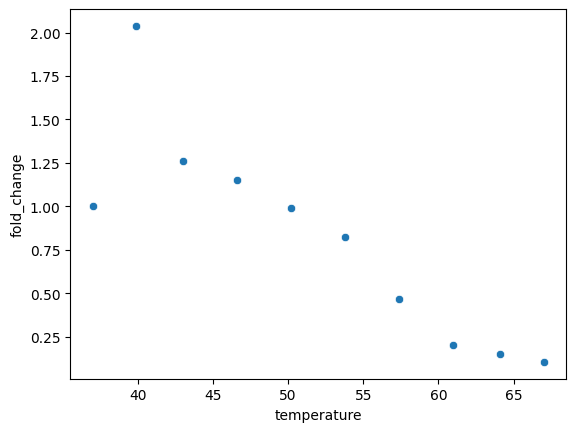

run_name                               object
Protein_ID                             object
gene_name                              object
meltPoint                              object
channel                                object
fold_change                           float64
temperature                           float64
From                                   object
Entry                                  object
Reviewed                               object
Entry Name                             object
Protein names                          object
Gene Names                             object
Organism                               object
Length                                float64
Gene Ontology (biological process)     object
Gene Ontology (cellular component)     object
Gene Ontology (molecular function)     object
Temperature dependence                 object
Sequence                               object
dtype: object


In [138]:
species_Ecoli_cells = species_prokaryotes[species_prokaryotes['run_name'].isin(['Escherichia coli cells'])]
species_Ecoli_cells.head()

#reassign floats to values bcs they change after extracting e.coli (why???)
species_Ecoli_cells['fold_change'] = species_Ecoli_cells['fold_change'].astype('float64') # changes fold_change column to float64
species_Ecoli_cells['temperature'] = species_Ecoli_cells['temperature'].astype('float64') # changes temperature column to int64
species_Ecoli_cells['Length'] = species_Ecoli_cells['Length'].astype('float64') # changes Length column to int64

species_Ecoli_cells_lacZ = species_Ecoli_cells[species_Ecoli_cells['gene_name'].isin(['lacZ'])]
species_Ecoli_cells_rpmF=species_Ecoli_cells[species_Ecoli_cells['gene_name'].isin(['rpmF'])]
sns.scatterplot(data=species_Ecoli_cells_lacZ, x='temperature', y='fold_change')
plt.show()
print(species_Ecoli_cells_lacZ.dtypes)


Create a list of each unique protein for each organism

In [139]:
# prokaryotes
prokaryotes_unique = species_prokaryotes.drop_duplicates(subset=['run_name', 'Protein_ID'], keep='first') #create new dataframe with only unique proteins
prokaryotes_unique = prokaryotes_unique.reset_index(drop=True) #reset index

# eukaryotes
eukaryotes_unique = species_eukaryotes.drop_duplicates(subset=['run_name', 'Protein_ID'], keep='first') #create new dataframe with only unique proteins
eukaryotes_unique = eukaryotes_unique.reset_index(drop=True) #reset index


# define meltpoint as float64
prokaryotes_unique['meltPoint'] = prokaryotes_unique['meltPoint'].astype('float64') # changes meltpoint column to float64
eukaryotes_unique['meltPoint'] = eukaryotes_unique['meltPoint'].astype('float64') # changes meltpoint column to float64
prokaryotes_unique['temperature'] = prokaryotes_unique['temperature'].astype('float64')

Define amino acid properties

In [140]:

## aminoacid composition
AA_hydrophobic:list = ['A', 'V', 'I', 'L', 'M', 'F', 'W', ]
AA_polar_neutral:list = ['N', 'Q', 'S', 'T', 'Y']
AA_acidic:list = ['D', 'E']
AA_basic:list = ['R', 'H', 'K']


Calculate relative abundance of hydrophobic aminoacids for each protein and append to dataframe

In [141]:
from function import rel_aa_comp 
prokaryotes_unique['hydrophobic'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, AA_hydrophobic)) # calculates relative amino acid composition of hydrophobic amino acids
prokaryotes_unique['polar_neutral'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, AA_polar_neutral)) # calculates relative amino acid composition of polar neutral amino acids
prokaryotes_unique['acidic'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, AA_acidic)) # calculates relative amino acid composition of acidic amino acids
prokaryotes_unique['basic'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, AA_basic)) # calculates relative amino acid composition of basic amino acids



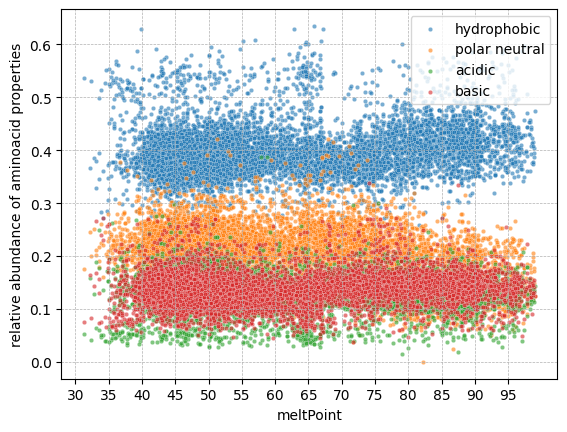

In [142]:
sns.scatterplot(data = prokaryotes_unique, x = 'meltPoint', y = 'hydrophobic', label = 'hydrophobic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes_unique, x='meltPoint', y='polar_neutral', label = 'polar neutral', s= 10, alpha = 0.6)
sns.scatterplot(data= prokaryotes_unique, x='meltPoint', y='acidic', label = 'acidic', s= 10, alpha = 0.6)
sns.scatterplot(data=prokaryotes_unique, x='meltPoint', y='basic', label = 'basic', s= 10, alpha = 0.6)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



In [143]:

# Align the indices of endog and exog variables
prokaryotes_unique_na = prokaryotes_unique.dropna(subset=['hydrophobic', 'meltPoint'])  # Drop rows with missing values
prokaryotes_unique = prokaryotes_unique.reset_index(drop=True)  # Reset the index

# Add a constant to the independent value
X = sm.add_constant(prokaryotes_unique_na['meltPoint'])

# Fit the model
model = sm.OLS(prokaryotes_unique_na['hydrophobic'], X)
results = model.fit()

# Print out the statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            hydrophobic   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     187.1
Date:                Sun, 05 May 2024   Prob (F-statistic):           3.94e-42
Time:                        20:04:45   Log-Likelihood:                 13756.
No. Observations:                8424   AIC:                        -2.751e+04
Df Residuals:                    8422   BIC:                        -2.749e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3738      0.002    187.964      0.0

Calculate average hydrophic content for each organism and plot vs living temperature of organism

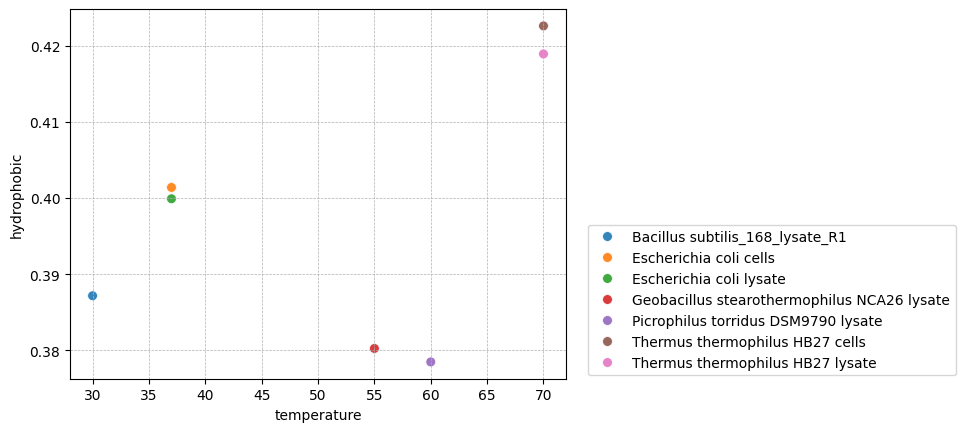

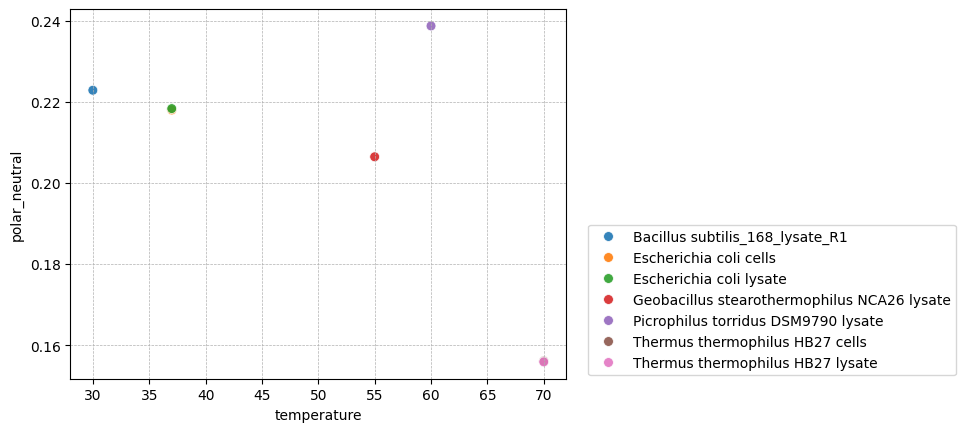

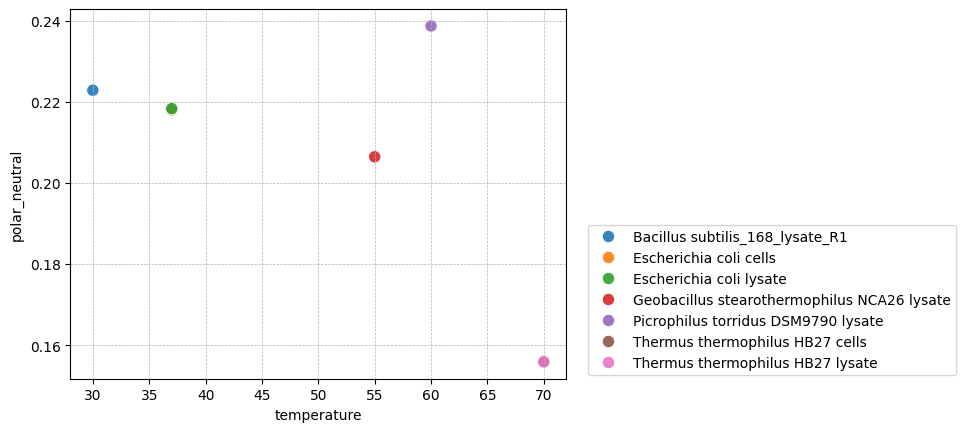

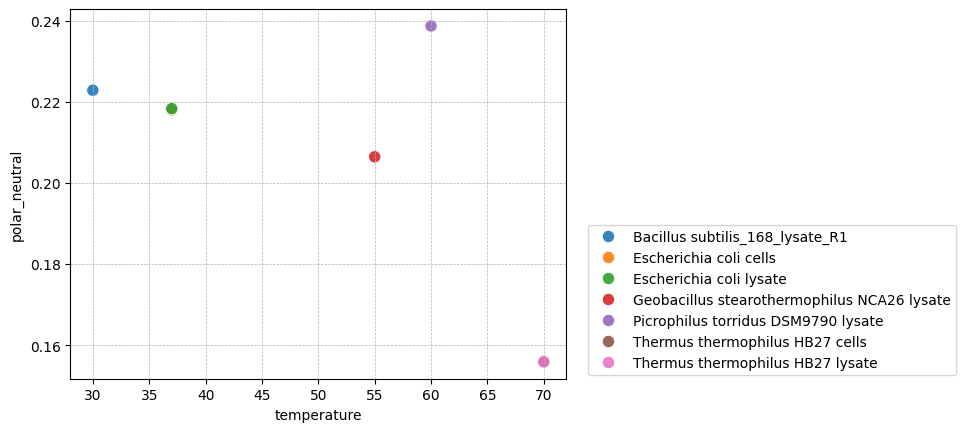

In [144]:
prokaryotes_unique_group = prokaryotes_unique.groupby('run_name')
prokaryotes_average = prokaryotes_unique_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic'])
prokaryotes_averages = prokaryotes_average.reset_index()

#plot hydrophobic agaisnt temp
sns.scatterplot(data = prokaryotes_averages, x = 'temperature', y = 'hydrophobic', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot polar_neutral against temp
sns.scatterplot(data = prokaryotes_averages, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot acidic against temp
sns.scatterplot(data = prokaryotes_averages, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#Plot basic against temp
sns.scatterplot(data = prokaryotes_averages, x = 'temperature', y ='polar_neutral', hue = 'run_name', s= 80, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Test for lysine and aspartic acid as indicator for stable and unstable proteins, respectively

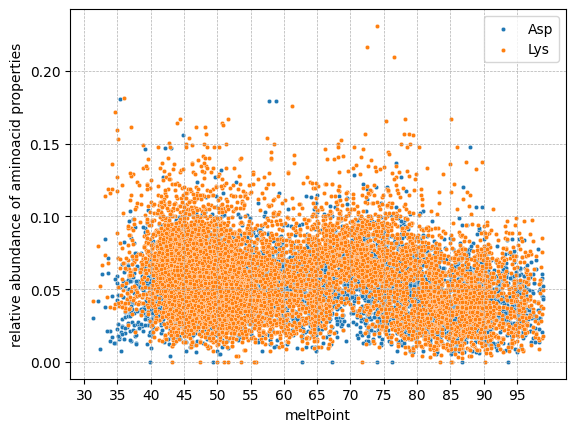

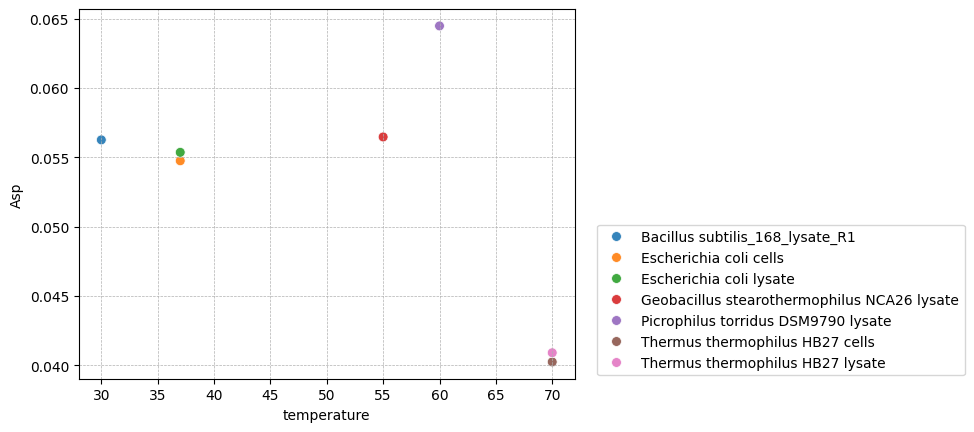

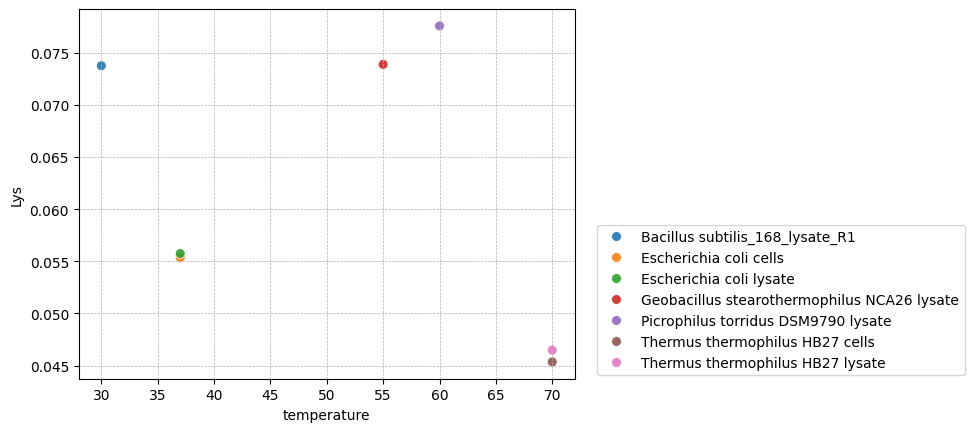

In [145]:
prokaryotes_unique['Asp'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, ['D'])) # calculates relative Asp abundance
prokaryotes_unique['Lys'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, ['K'])) # calculates relative Glu abundance

#plot individual proteins
sns.scatterplot(data=prokaryotes_unique, x='meltPoint', y='Asp', label = 'Asp', s= 10, alpha = 1)
sns.scatterplot(data=prokaryotes_unique, x='meltPoint', y='Lys', label = 'Lys', s= 10, alpha = 1)
plt.xticks(np.arange(30, 100, 5))
plt.ylabel('relative abundance of aminoacid properties')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#avg protein of each organism
prokaryotes_unique_group = prokaryotes_unique.groupby('run_name')
prokaryotes_average = prokaryotes_unique_group.mean(['temperature', 'hydrophobic', 'acidic', 'polar_neutral', 'basic', 'Asp', 'Lys'])
prokaryotes_averages = prokaryotes_average.reset_index()


#plot avg Asp contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_averages, x = 'temperature', y = 'Asp', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

#plot avg Lys contant of each organism agaisnt OGT
sns.scatterplot(data = prokaryotes_averages, x = 'temperature', y = 'Lys', hue = 'run_name', s= 50, alpha = 0.9)
plt.legend(loc= 'lower right', bbox_to_anchor=(1.8, -0.01))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


Test for all other amino acids

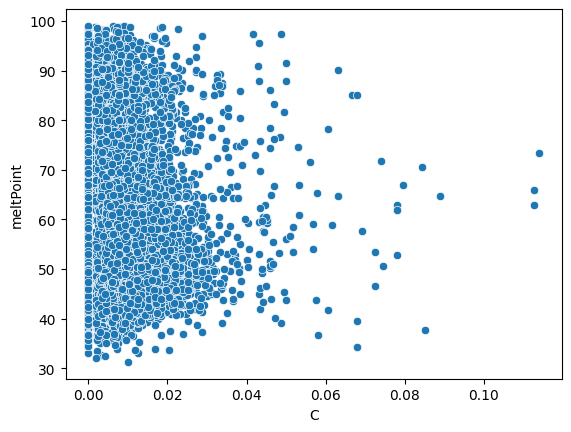

<bound method DataFrame.corr of                                   run_name      Protein_ID gene_name  \
0         Thermus thermophilus HB27 lysate      Q9RA48_ORF       ORF   
1          Thermus thermophilus HB27 cells      Q9RA48_ORF       ORF   
2      Picrophilus torridus DSM9790 lysate  Q6L362_PTO0004   PTO0004   
3      Picrophilus torridus DSM9790 lysate  Q6L361_PTO0005   PTO0005   
4      Picrophilus torridus DSM9790 lysate  Q6L360_PTO0006   PTO0006   
...                                    ...             ...       ...   
10736      Thermus thermophilus HB27 cells         Q846D1_       NaN   
10737      Thermus thermophilus HB27 cells         Q846D3_       NaN   
10738      Thermus thermophilus HB27 cells         Q8GR83_       NaN   
10739      Thermus thermophilus HB27 cells         Q8GR84_       NaN   
10740      Thermus thermophilus HB27 cells         Q9ZAF1_       NaN   

       meltPoint channel  fold_change  temperature    From   Entry  \
0            NaN  TMT126     1.00

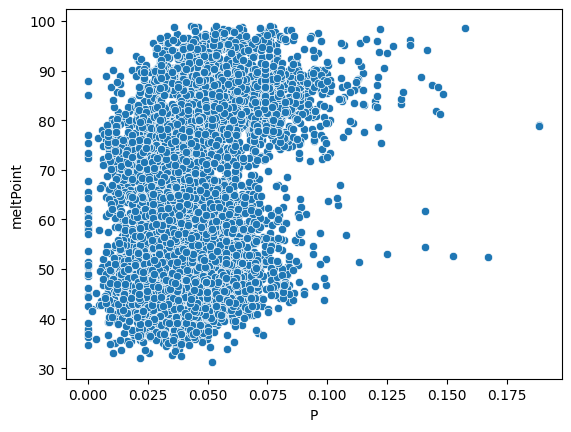

In [146]:
prokaryotes_unique['Asp'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, ['D'])) # calculates relative Asp abundance
prokaryotes_unique['Lys'] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, ['K'])) # calculates relative Glu abundance
AA_list:list = ['A', 'V', 'I', 'L', 'M', 'F', 'W','N', 'Q', 'S', 'T', 'Y','D', 'E','R', 'H', 'K', 'C', 'P' ]
for i in range(len(AA_list)):
    prokaryotes_unique[str(AA_list[i])] = prokaryotes_unique['Sequence'].apply(lambda x: rel_aa_comp(x, [str(AA_list[i])])) # calculates relative protein abundance

sns.scatterplot(data=prokaryotes_unique, x='C', y='meltPoint')
plt.show()
sns.scatterplot(data=prokaryotes_unique, x='P', y='meltPoint')

prokaryotes_unique.corr

calculate the correlation between amino acids and the melting tm 
dataframe with all amino acids and their orrelations to the metling temp if corr > 0.25

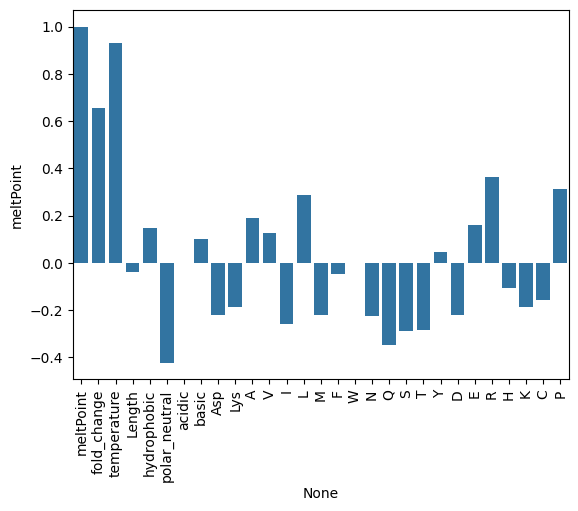

In [152]:
prokaryotes_unique_cor = prokaryotes_unique.corr('pearson', numeric_only= True)
prokaryotes_unique_cor
#meltpoint_temp = prokaryotes_unique_cor.iloc[0,[]]
#threshold = (0.25)

#for n in range(len(prokaryotes_unique_cor.columns)):
#    if prokaryotes_unique_cor.loc[0,str(n)] <= threshold:
#        prokaryotes_unique_cor.drop(axis = 1, labels = str(n))


sns.barplot(prokaryotes_unique_cor, x= prokaryotes_unique_cor.columns , y='meltPoint')
plt.xticks(rotation = 90)
plt.show()




In [ ]:
meltpoint_temp.drop()

meltPoint        1.000000
fold_change      0.655925
temperature      0.929361
Length          -0.040303
hydrophobic      0.147402
polar_neutral   -0.422105
acidic          -0.000289
basic            0.099431
Asp             -0.221776
Lys             -0.188455
A                0.190213
V                0.126077
I               -0.257807
L                0.288958
M               -0.220563
F               -0.046176
W               -0.000954
N               -0.224083
Q               -0.345823
S               -0.289520
T               -0.285497
Y                0.045095
D               -0.221776
E                0.160017
R                0.365117
H               -0.105590
K               -0.188455
C               -0.157564
P                0.312844
Name: meltPoint, dtype: float64


In [ ]:
prokaryotes_unique.head()


,run_name,Protein_ID,gene_name,meltPoint,channel,fold_change,temperature,From,Entry,Reviewed,...,Q,S,T,Y,D,E,R,H,K,C
0,Thermus thermophilus HB27 lysate,Q9RA48_ORF,ORF,NaN,TMT126,1.000000,70.0,Q9RA48,Q9RA48,unreviewed,...,0.040816,0.015306,0.066327,0.030612,0.056122,0.076531,0.056122,0.035714,0.040816,0.005102
1,Thermus thermophilus HB27 cells,Q9RA48_ORF,ORF,NaN,TMT126,0.999896,70.0,Q9RA48,Q9RA48,unreviewed,...,0.040816,0.015306,0.066327,0.030612,0.056122,0.076531,0.056122,0.035714,0.040816,0.005102
2,Picrophilus torridus DSM9790 lysate,Q6L362_PTO0004,PTO0004,NaN,TMT126,0.999820,60.0,Q6L362,Q6L362,unreviewed,...,0.011834,0.059172,0.005917,0.088757,0.088757,0.053254,0.053254,0.035503,0.100592,0.029586
3,Picrophilus torridus DSM9790 lysate,Q6L361_PTO0005,PTO0005,64.707335,TMT126,0.999820,60.0,Q6L361,Q6L361,unreviewed,...,0.027634,0.056995,0.036269,0.048359,0.074266,0.065630,0.044905,0.012090,0.094991,0.012090
4,Picrophilus torridus DSM9790 lysate,Q6L360_PTO0006,PTO0006,80.470376,TMT126,0.999820,60.0,Q6L360,Q6L360,unreviewed,...,0.013699,0.050228,0.041096,0.095890,0.041096,0.031963,0.022831,0.018265,0.073059,0.000000
